# TP2: Regresión del valor de valor medio de casas en distritos de California

Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

Y el target es:

- `MedHouseVal`: Mediana del costo de casas en el bloque (en unidades de a $100.000)

Para este TP, se proporciona una notebook (`ayuda.ipynb`) con la lectura del dataset, la separación de los datos, entre 
otras ayudas para resolver este trabajo práctico.

## Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación 
lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o 
directamente graficar usando un mapa de calor.
2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se 
observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin 
entrar en pruebas de hipótesis?
3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del 
modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su 
respuesta.
4. Calcular las métricas de MSE, MAE y $R^2$ del set de evaluación.
5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el 
mejor valor de $\alpha$, buscando entre [0, 12.5]. Graficar el valor de MSE versus $\alpha$.
6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. 
¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse 
reducido?

El entregable consiste en uno o más archivos de notebook `ipynb` con las respuestas. Aunque se da libertad para usar 
otros tipos de entregables, es importante incluir tanto el código de lo resuelto como las respuestas. Pueden subir 
el contenido o proporcionar un enlace a un repositorio público (GitHub o GitLab) con el contenido en el aula virtual. 
**No olviden especificar los autores del TP en el entregable**.

Para resolver este TP, son libres de utilizar los recursos que consideren necesarios. Pueden hacerlo en cualquier 
lenguaje de programación y de la forma que consideren apropiada.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
sns.set()

In [15]:
# Download california bunch
california_bunch = fetch_california_housing()


In [16]:
california_dataframe = pd.DataFrame(np.c_[california_bunch['data'] ,california_bunch['target']], columns=california_bunch['feature_names']+california_bunch['target_names'])

# X = pd.DataFrame(california_bunch['data'], columns=california_bunch['feature_names'])
# y = pd.Series(california_bunch['target'], name=california_bunch['target_names'][0])
# california_dataframe.describe()

Sacamos los ouliers

In [17]:
from scipy import stats
import numpy as np

# Calcular Z-Score para AveRooms
z_scores = np.abs(stats.zscore(california_dataframe['AveRooms']))

# Umbral típico es 3
threshold = 3

# Filtrar los outliers
california_dataframe = california_dataframe[z_scores < threshold]

z_scores = np.abs(stats.zscore(california_dataframe['AveBedrms']))

california_dataframe = california_dataframe[z_scores < threshold]

# Q1 = california_dataframe['MedHouseVal'].quantile(0.25)
# Q3 = california_dataframe['MedHouseVal'].quantile(0.75)
# IQR = Q3 - Q1

# Definir límites para detectar outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
# california_dataframe = california_dataframe[(california_dataframe['MedHouseVal'] >= lower_bound) & (california_dataframe['MedHouseVal'] <= upper_bound)]


print(f"Forma original del dataset: {california_dataframe.shape}")
# print(f"Forma del dataset sin outliers: {california_dataframe_cleaned.shape}")

Forma original del dataset: (20146, 9)


1.Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación 
lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o 
directamente graficar usando un mapa de calor.

MedInc        0.690633
HouseAge      0.101284
AveRooms      0.359453
AveBedrms    -0.077033
Population   -0.033540
AveOccup     -0.024455
Latitude     -0.137813
Longitude    -0.046827
Name: MedHouseVal, dtype: float64


<Axes: >

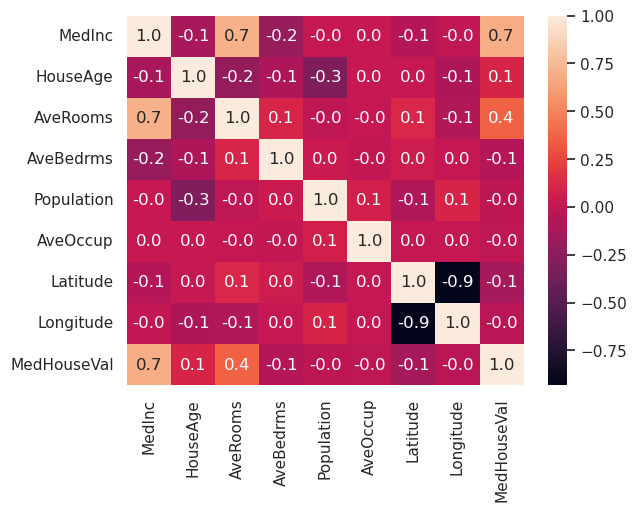

In [5]:


# Correlation
california_correlation = california_dataframe.corr()
california_correlation_with_target = california_correlation['MedHouseVal'].drop('MedHouseVal')
print(california_correlation_with_target)
sns.heatmap(california_correlation, annot=True, fmt=".1f")

Del la lectura del mapa de calor, se observa que el atributo con mayor correlación con el target (MedHouseVale), es MedInc.
A su vez, AveRooms y AveBedrms son los atributos que parecería estar más correlacionados. 

2.Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se 
observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin 
entrar en pruebas de hipótesis?

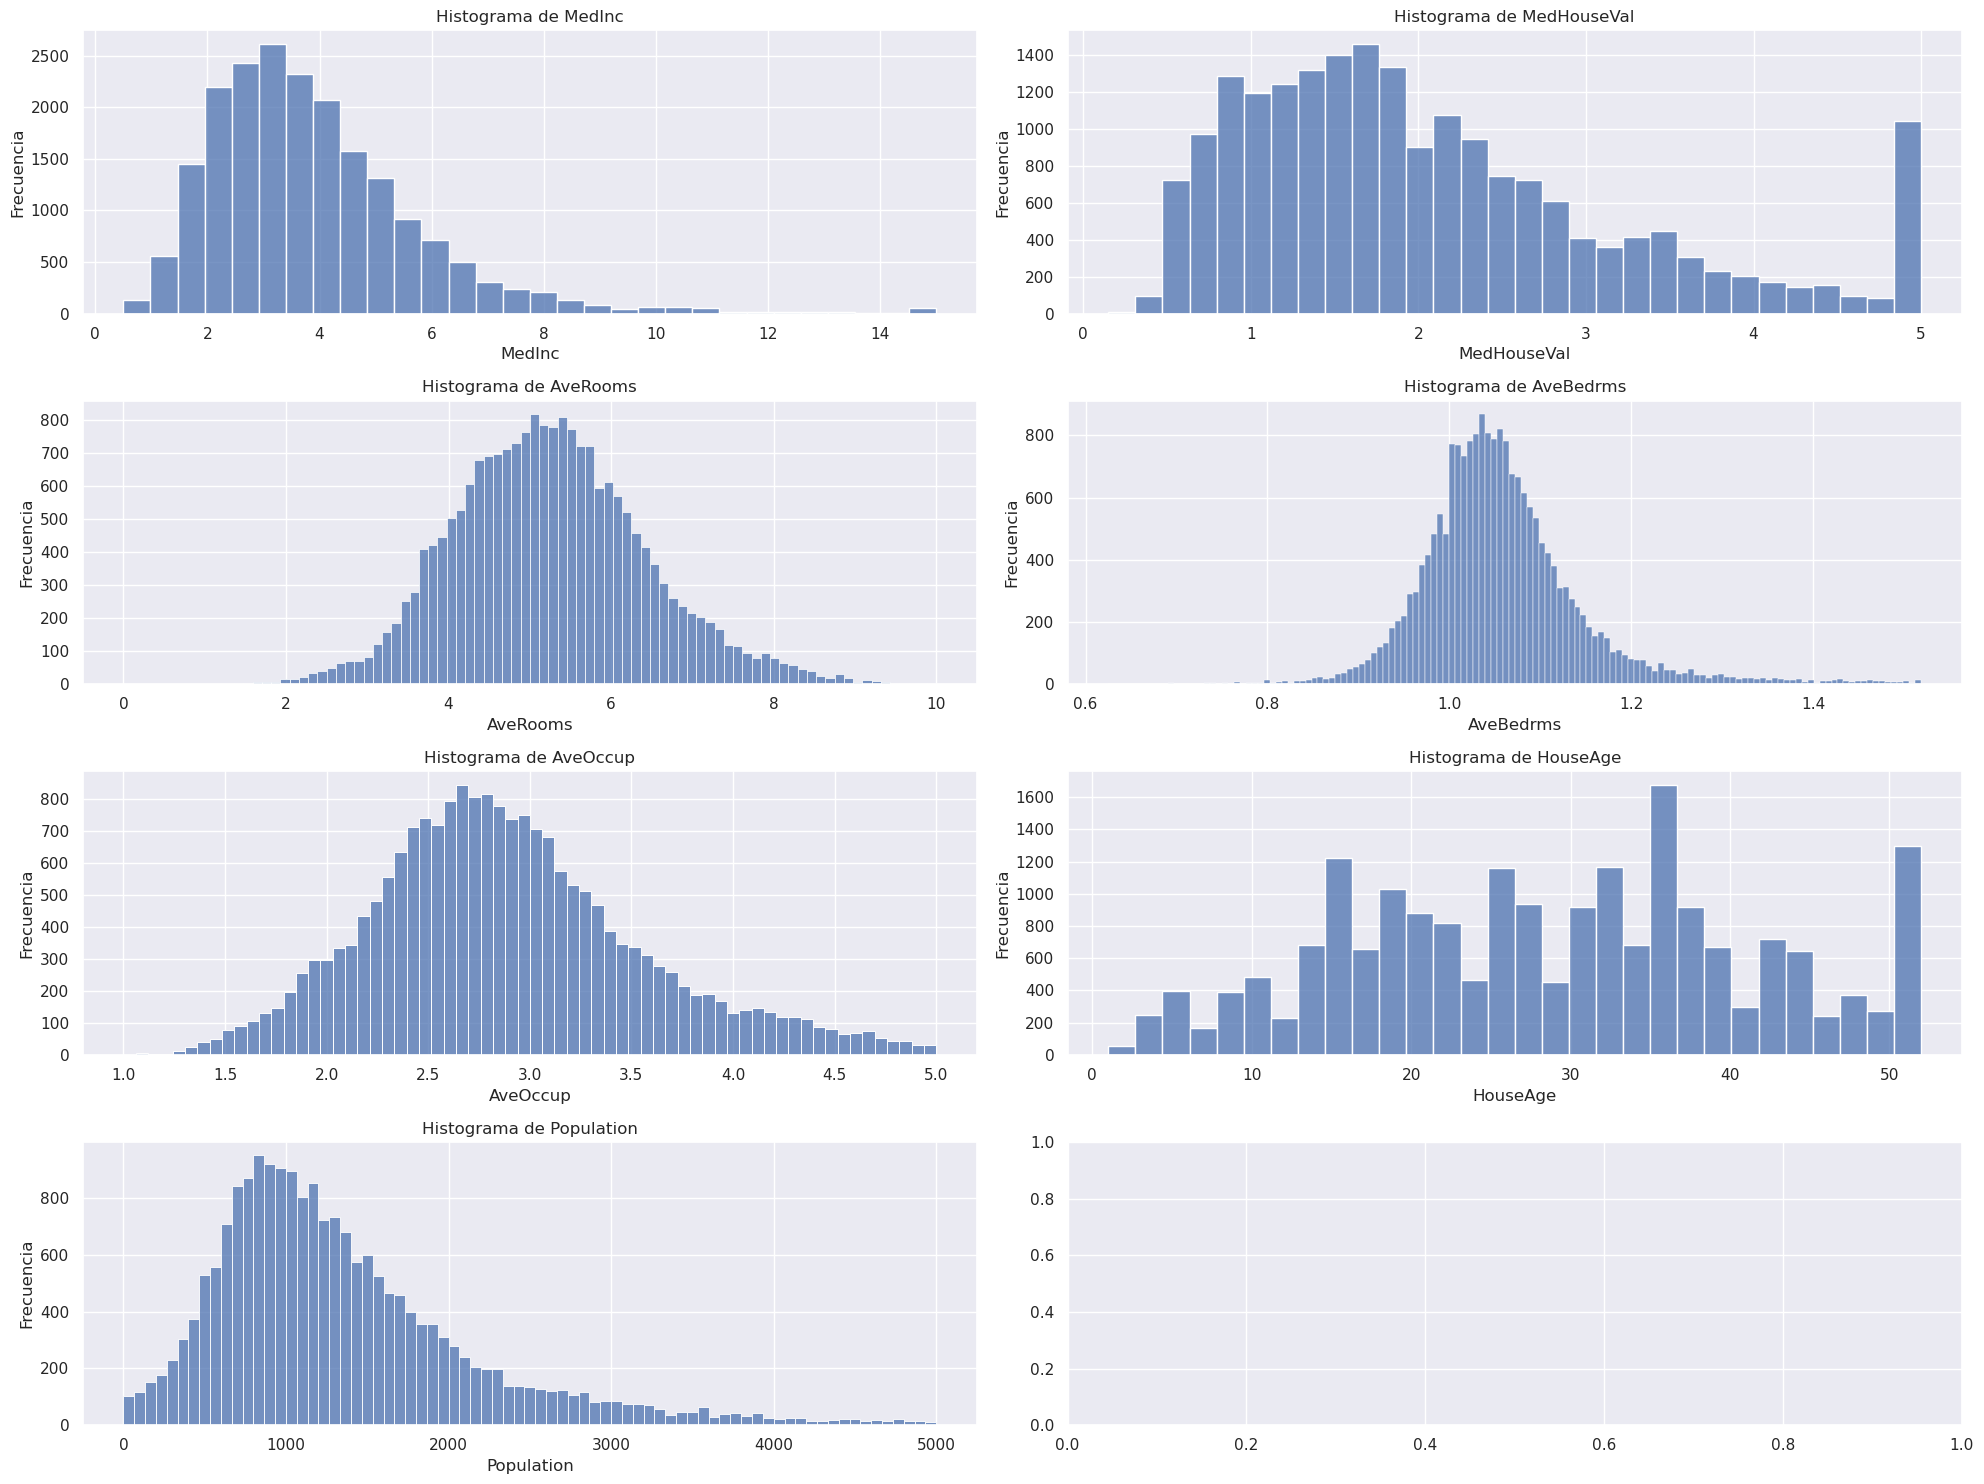

In [6]:
ncols = len(california_dataframe.columns)//4
nrows=4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

# Histograma

def histo_graph(col, x, y, bins='auto', binwidth=None, binrange=None):
    sns.histplot(california_dataframe[col], bins=bins, binwidth=binwidth, binrange=binrange, kde=False, ax=axes[x][y])
    axes[x][y].set_title(f'Histograma de {col}')
    axes[x][y].set_xlabel(col)
    axes[x][y].set_ylabel('Frecuencia')
    
# MedInc 
histo_graph('MedInc', 0, 0, 30)
# MedHouseValue
histo_graph('MedHouseVal', 0, 1, 30)
# AveRooms
histo_graph('AveRooms', 1, 0, binrange=(0,10))
# AveBedrms
histo_graph('AveBedrms', 1, 1)
# AveOccup
histo_graph('AveOccup', 2, 0, binrange=(1,5))
# HouseAge
histo_graph('HouseAge', 2, 1, 30)
# Population
histo_graph('Population', 3, 0, binrange=(0,5000))

plt.tight_layout()
plt.show()

Para el caso de los histogramas de los feature MedInc, AveRooms, AveBedrms, AveOccup, Population se observa la forma de campana por lo tanto los datos podrían provenir de una distribución gaussiana.

In [28]:
california_dataframe.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


3.Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

In [23]:
# Preparamos los dataset
X = california_dataframe.drop('MedHouseVal', axis=1).drop("HouseAge", axis=1)
y = pd.Series(california_dataframe['MedHouseVal'])

print("Cantidad de elementos en 'X':", X.shape)
print("Cantidad de elementos en 'y':", y.shape)

# Sin escalar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Valores de X_train:", X_train.size)
print("Valores de y_train:", y_train.size)
print("Valores de X_test:", X_test.size)
print("Valores de y_test:", y_test.size)



# Escalado
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Cantidad de elementos en 'X': (20146, 7)
Cantidad de elementos en 'y': (20146,)
Valores de X_train: 98714
Valores de y_train: 14102
Valores de X_test: 42308
Valores de y_test: 6044


In [24]:
# Entrenamos el modelo
regresion = LinearRegression()
regresion.fit(X_train, y_train)

regresion_scaled = LinearRegression()
regresion_scaled.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
print(f"Coeficiente de regresion: {regresion.coef_}")
print(f"Coeficiente de intercept: {regresion.intercept_}")

print(f"Escalado Coeficiente de regresion: {regresion_scaled.coef_}")
print(f"Escalado Coeficiente de intercept: {regresion_scaled.intercept_}")


Coeficiente de regresion: [ 4.63469636e-01 -1.68817191e-01  1.68343439e+00 -3.99436885e-05
 -3.55732772e-03 -4.59311099e-01 -4.79632081e-01]
Coeficiente de intercept: -41.55059109820245
Escalado Coeficiente de regresion: [ 0.88484149 -0.20425348  0.14967971 -0.04402438 -0.04140117 -0.97135821
 -0.95560969]
Escalado Coeficiente de intercept: 2.0740746482768455


In [26]:
# Cálculo del desvio estandar del modelo
std_dev_model = np.sqrt((np.sum((y_test - regresion.predict(X_test))**2))/(y_test.size-X_test.shape[1]-1))
print(f"Coeficiente de std dev: {std_dev_model}")
# Cálculo del desvio estandar del modelo
std_dev_model_scaled = np.sqrt((np.sum((y_test - regresion_scaled.predict(X_test_scaled))**2))/(y_test.size-X_test.shape[1]-1))
print(f"Coeficiente de std dev escalado: {std_dev_model_scaled}")

Coeficiente de std dev: 0.7203252104091737
Coeficiente de std dev escalado: 0.7203252104091742


In [27]:
# from scipy.stats import pearsonr
# pearson_coef = pearsonr(y_test, regresion.predict(X_test))
# pearson_coef_scaled = pearsonr(y_test, regresion_scaled.predict(X_test_scaled))

# print(f"El coeficiente de Pearson es {pearson_coef.statistic}")
# print(f"El coeficiente de Pearson SCALED es {pearson_coef_scaled.statistic}")

print(f"El coeficiente de Pearson es {regresion.score(X_test, y_test)}")
print(f"El coeficiente de Pearson SCALED es {regresion_scaled.score(X_train_scaled, y_train)}")

El coeficiente de Pearson es 0.6149514300487247
El coeficiente de Pearson SCALED es 0.6128159455671212


4.Calcular las métricas de MSE, MAE y $R^2$ del set de evaluación.

In [39]:
y_pred = regresion.predict(X_test)
y_pred_scaled = regresion_scaled.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse_scaled = mean_squared_error(y_test, y_pred_scaled)
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

y_test_values = y_test.values 
print(f"Varieble test {y_test_values[10]} y variable modelo {y_pred_scaled[10]}")
bias = np.mean(y_pred_scaled - y_test_values)
print("Bias:", bias)

residuos = y_pred - y_test
# print("Residuos:", residuos)

SSR = np.sum(residuos**2)

# Calcular el error de varianza
n = len(y_pred)
sigma_squared = SSR / (n - 2)

# Calcular el error estándar de la estimación
sigma = np.sqrt(sigma_squared)
print("Sigma:", sigma)

Varieble test 1.25 y variable modelo 1.3714981452513018
Bias: -0.026917559394008396
Sigma: 0.719967462579604


In [32]:
print("MSE:", mse)
print("MSE SCALED:", mse_scaled)
print("MSE DIFF:", mse-mse_scaled)
print("MAE:", mae)
print("MAE SCALED:", mae_scaled)
print("MAE DIFF:", mae-mae_scaled)
print("R2:", r2)
print("R2 SCALED:", r2_scaled)
print("R2 DIFF:", r2_scaled-r2_scaled)

MSE: 0.518181620652078
MSE SCALED: 0.5181816206520786
MSE DIFF: -6.661338147750939e-16
MAE: 0.5268937324501559
MAE SCALED: 0.5268937324501579
MAE DIFF: -1.9984014443252818e-15
R2: 0.6149514300487247
R2 SCALED: 0.6149514300487242
R2 DIFF: 0.0


Ouliers

In [69]:
from scipy import stats
import numpy as np

# Calcular el Z-Score para cada valor en el dataframe
z_scores = np.abs(stats.zscore(california_dataframe.select_dtypes(include=np.number)))

# Identificar outliers con un umbral de 3
outliers = np.where(z_scores > 3)

california_df_cleaned = california_dataframe[(z_scores < 3).all(axis=1)]
print("California con outliers:", california_dataframe.shape)
print("Sin ouliers:", california_df_cleaned.shape)
# plt.figure(figsize=(12,10))
# california_dataframe_without_population = california_dataframe.drop(columns=['population'])
# sns.boxplot(data=california_dataframe.drop(columns=['Population']))
# plt.title('Boxplot de las Variables Numéricas')
# plt.show()

# plt.figure(figsize=(12,10))
# california_dataframe_without_population = california_dataframe.drop(columns=['population'])
# sns.boxplot(data=california_df_cleaned.drop(columns=['Population']))
# plt.title('Boxplot de las Variables Numéricas SIN OUTLIERS')
# plt.show()

California con outliers: (20640, 9)
Sin ouliers: (19794, 9)


In [62]:
X_sin_ouliers = california_df_cleaned.drop(columns=['MedHouseVal'])
y_sin_ouliers = pd.Series(california_df_cleaned['MedHouseVal'])

print("Cantidad de elementos en 'X':", X_sin_ouliers.shape)
print("Cantidad de elementos en 'y':", y_sin_ouliers.shape)

# Sin escalar
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_sin_ouliers, y_sin_ouliers, test_size=0.3, random_state=42)
print("Valores de X_train:", X_train_out.size)
print("Valores de y_train:", y_train_out.size)
print("Valores de X_test:", X_test_out.size)
print("Valores de y_test:", y_test_out.size)



# Escalado
scaler = StandardScaler()

X_train_out_scaled = scaler.fit_transform(X_train_out)
X_test_out_scaled = scaler.transform(X_test_out)

Cantidad de elementos en 'X': (19794, 8)
Cantidad de elementos en 'y': (19794,)
Valores de X_train: 110840
Valores de y_train: 13855
Valores de X_test: 47512
Valores de y_test: 5939


In [66]:
regresion_out = LinearRegression()
regresion_out.fit(X_train_out_scaled, y_train_out)
y_pred_out = regresion_out.predict(X_test_out_scaled)


mse = mean_squared_error(y_test_out, y_pred_out)
mae = mean_absolute_error(y_test_out, y_pred_out)
r2 = r2_score(y_test_out, y_pred_out)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

std_dev_model = np.sqrt((np.sum((y_test_out - regresion_out.predict(X_test_out_scaled))**2))/(y_test_out.size-X_test_out_scaled.shape[1]-1))
print(f"Coeficiente de std dev: {std_dev_model}")

MSE: 0.471331948059489
MAE: 0.4963787170554103
R2: 0.6175173550951675
Coeficiente de std dev: 0.687056978464582


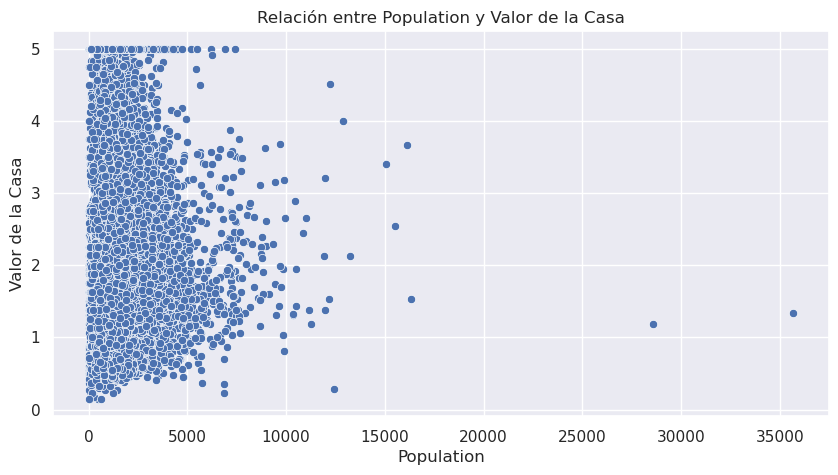

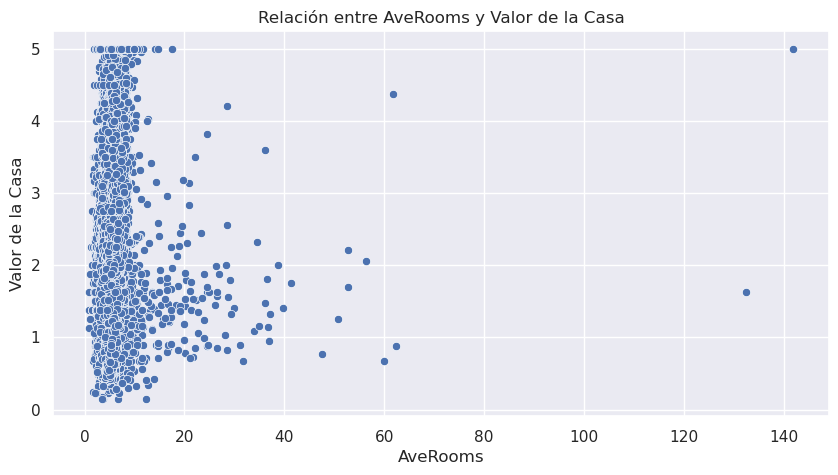

In [44]:
# Analizando relacion si existe relacion lineal entre la population y el valor de la vivienda
# Diagrama de dispersión para latitud y valor de la casa
plt.figure(figsize=(10, 5))
sns.scatterplot(x=california_dataframe['Population'], y=california_dataframe['MedHouseVal'])
plt.title('Relación entre Population y Valor de la Casa')
plt.xlabel('Population')
plt.ylabel('Valor de la Casa')
plt.show()

# Diagrama de dispersión para latitud y valor de la casa
plt.figure(figsize=(10, 5))
sns.scatterplot(x=california_dataframe['AveRooms'], y=california_dataframe['MedHouseVal'])
plt.title('Relación entre AveRooms y Valor de la Casa')
plt.xlabel('AveRooms')
plt.ylabel('Valor de la Casa')
plt.show()


# Analizando relacion si existe relacion lineal entre la latitud y longitud y el valor de la vivienda
# Diagrama de dispersión para latitud y valor de la casa
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=california_dataframe['Latitude'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Latitud y Valor de la Casa')
# plt.xlabel('Latitud')
# plt.ylabel('Valor de la Casa')
# plt.show()

# Diagrama de dispersión para longitud y valor de la casa
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=california_dataframe['Longitude'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Longitud y Valor de la Casa')
# plt.xlabel('Longitud')
# plt.ylabel('Valor de la Casa')
# plt.show()

# Diagrama de dispersión para longitud y valor de la casa
# plt.figure(figsize=(10, 5))
# california_dataframe['lat_long_interaction'] = california_dataframe['Latitude'] * california_dataframe['Longitude']
# sns.scatterplot(x=california_dataframe['lat_long_interaction'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Lat_long_intereaction y Valor de la Casa')
# plt.xlabel('Longitud')
# plt.ylabel('Valor de la Casa')
# plt.show()

from sklearn.cluster import KMeans

# Aplicar KMeans con un número de clusters adecuado
# kmeans = KMeans(n_clusters=10, random_state=0)
# california_dataframe['geo_cluster'] = kmeans.fit_predict(california_dataframe[['Latitude', 'Longitude']])

# Convertir los clusters en variables dummy
# df = pd.get_dummies(california_dataframe, columns=['geo_cluster'], drop_first=True)
# plt.figure(figsize=(10, 5))

# sns.scatterplot(x=california_dataframe['geo_cluster'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Geo Cluster y Valor de la Casa')
# plt.xlabel('Longitud')
# plt.ylabel('Valor de la Casa')
# plt.show()

# from geopy.distance import geodesic
# Calcular la distancia al centro de San Francisco
# city_center = (37.7749, -122.4194)  # Coordenadas de San Francisco
# california_dataframe['distance_to_city_center'] = california_dataframe.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), city_center).miles, axis=1)
# sns.scatterplot(x=california_dataframe['distance_to_city_center'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Distance y Valor de la Casa')
# plt.xlabel('Longitud')
# plt.ylabel('Valor de la Casa')
# plt.show()

# plt.figure(figsize=(10, 10))
# sns.scatterplot(x=california_dataframe['MedInc'], y=california_dataframe['MedHouseVal'])
# plt.title('Relación entre Ingresos y Valor de la Casa')
# plt.xlabel('Ingesos')
# plt.ylabel('Valor de la Casa')
# plt.show()

# plt.figure(figsize=(10, 8))
# sns.scatterplot(data=california_dataframe, x='Longitude', y='Latitude', hue='MedHouseVal', palette='viridis')
# plt.title('Valor de la Casa en función de la Latitud y Longitud')
# plt.show()

De los graficos se observa que no hay una relacion lineal 

In [7]:
from scipy.stats import pearsonr

# Correlación entre latitud y valor de la casa
corr_lat, _ = pearsonr(california_dataframe['Latitude'], california_dataframe['MedHouseVal'])
print(f'Coeficiente de correlación entre latitud y valor de la casa: {corr_lat}')

# Correlación entre longitud y valor de la casa
corr_long, _ = pearsonr(california_dataframe['Longitude'], california_dataframe['MedHouseVal'])
print(f'Coeficiente de correlación entre longitud y valor de la casa: {corr_long}')

Coeficiente de correlación entre latitud y valor de la casa: -0.14416027687465963
Coeficiente de correlación entre longitud y valor de la casa: -0.04596661511797841


In [10]:
import statsmodels.api as sm

# Añadir un término de intercepción
X_geo = sm.add_constant(california_dataframe[['Latitude', 'Longitude']])
y_geo = california_dataframe['MedHouseVal']

# Ajustar el modelo de regresión lineal
model = sm.OLS(y_geo, X_geo).fit()

# Resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     3302.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:50:09   Log-Likelihood:                -29377.
No. Observations:               20640   AIC:                         5.876e+04
Df Residuals:                   20637   BIC:                         5.878e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.2940      0.821    -71.010      0.0

In [15]:
california_dataframe['lat_long_interaction'] = california_dataframe['Latitude'] * california_dataframe['Longitude']

# Análisis de la regresión lineal con la interacción
X_plus = sm.add_constant(california_dataframe[['lat_long_interaction']])
y_plus = california_dataframe['MedHouseVal']
model = sm.OLS(y_plus, X_plus).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     228.0
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           3.11e-51
Time:                        16:08:49   Log-Likelihood:                -32129.
No. Observations:               20640   AIC:                         6.426e+04
Df Residuals:                   20638   BIC:                         6.428e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.6566 

In [28]:
from sklearn.cluster import KMeans

# Aplicar KMeans con un número de clusters adecuado
kmeans = KMeans(n_clusters=10, random_state=0)
california_dataframe['geo_cluster'] = kmeans.fit_predict(california_dataframe[['Latitude', 'Longitude']])

# Convertir los clusters en variables dummy
df = pd.get_dummies(california_dataframe, columns=['geo_cluster'], drop_first=True)

# Análisis de la regresión lineal con los clusters
X_kmeas = sm.add_constant(california_dataframe.drop(columns=['MedHouseVal', 'lat_long_interaction','Population', 'HouseAge',  'AveOccup', 'AveOccup', 'AveBedrms', 'AveRooms']))
y_kmeas = df['MedHouseVal']
model = sm.OLS(y_kmeas, X_kmeas).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     7254.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:32:45   Log-Likelihood:                -23180.
No. Observations:               20640   AIC:                         4.637e+04
Df Residuals:                   20635   BIC:                         4.641e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -42.2366      0.647    -65.234      

/opt/miniconda3/envs/condaEnv3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [76]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)



LinearRegression()

In [78]:
print(f"Coeficiente de regresion: {lin_reg.coef_}")
print(f"Coeficiente de intercept: {lin_reg.intercept_}")

y_pred = lin_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

Coeficiente de regresion: [ 9.76730367e-01  1.83955492e-01 -1.96788443e-01  7.28338167e-02
 -7.26093015e-04 -2.86032692e-03 -1.58206890e+00 -1.64367743e+00]
Coeficiente de intercept: 2.023332134484552
MSE: 0.530567782476675
MAE: 0.5272474538305953
R2: 0.5957702326061665


5.Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de $\alpha$, buscando entre [0, 12.5]. Graficar el valor de MSE versus $\alpha$.

In [42]:
coeffs_ridge = np.zeros([5000, 8])

coeffs_ridge[0, :] = regresion.coef_.copy()

alpha_array = np.arange(0, 1, 12.5)

for index, alpha in enumerate(alpha_array):
    
    if index == 0:
        continue
        
    ridge_model = Ridge(alpha=alpha)
    
    ridge_model.fit(X_train, y_train)
    
    coeffs_ridge[index, :] = ridge_model.coef_.copy()

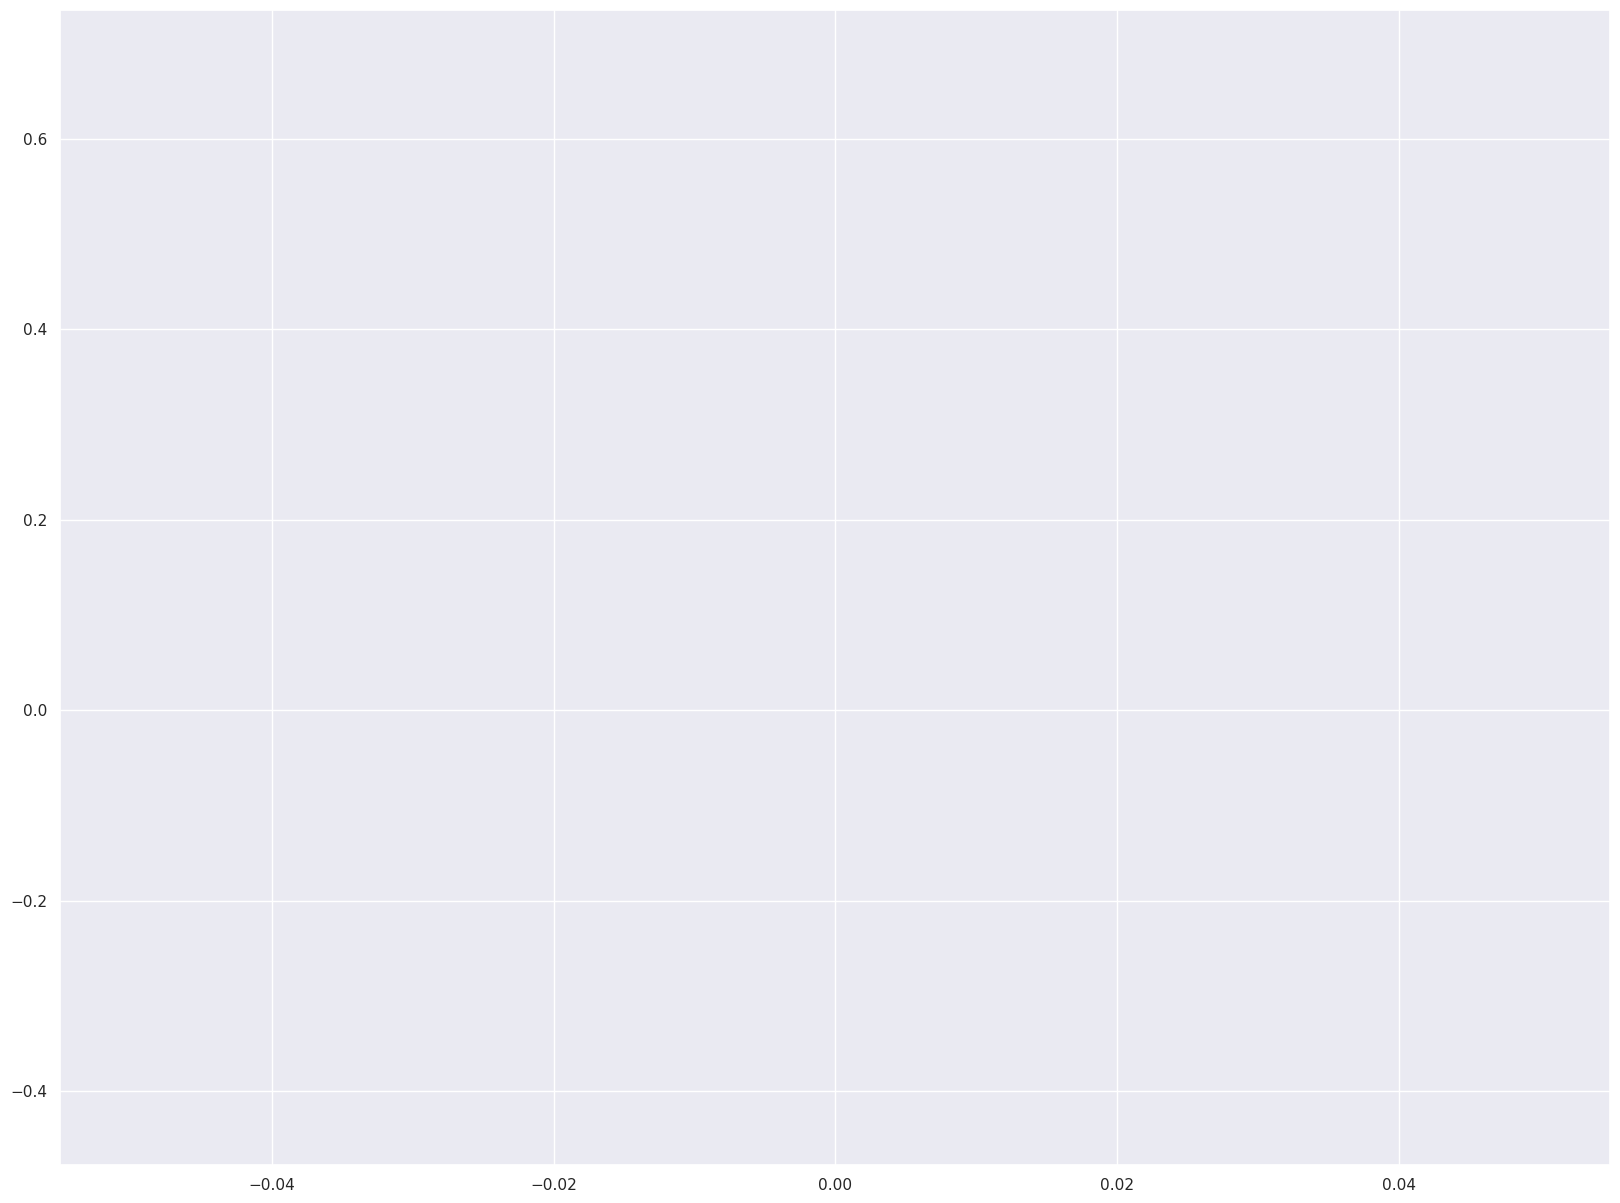

In [53]:
f, ax = plt.subplots(1,1, figsize=(20, 15))

for i in range(coeffs_ridge.shape[1]):
    ax.plot(alpha_array, coeffs_ridge[0, i], label=f'Ridge {i}')
    

    

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [39]:
kmeans = KMeans(n_clusters=10, random_state=0)
california_dataframe['cluster'] = kmeans.fit_predict(california_dataframe[['Latitude', 'Longitude']])

los_angeles_coords = np.array([-118.2437, 34.0522])
california_dataframe['distance_to_LA'] = pairwise_distances(california_dataframe[['Longitude', 'Longitude']], [los_angeles_coords]).flatten()

/home/l30659/miniconda3/envs/conda3_11/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
california_dataframe

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,cluster,distance_to_LA
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1,156.333031
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1,156.322780
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1,156.343283
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1,156.353536
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1,156.353536
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,8,155.168307
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,8,155.290533
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,8,155.300723
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,8,155.402652


MedInc            0.688075
HouseAge          0.105623
AveRooms          0.151948
AveBedrms        -0.046701
Population       -0.024650
AveOccup         -0.023737
Latitude         -0.144160
Longitude        -0.045967
cluster          -0.084163
distance_to_LA    0.045811
Name: MedHouseVal, dtype: float64


<Axes: >

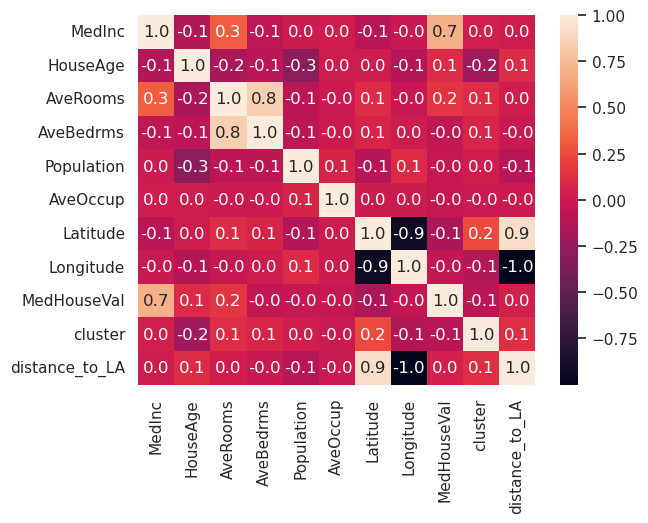

In [41]:
# Correlation
california_correlation = california_dataframe.corr()
california_correlation_with_target = california_correlation['MedHouseVal'].drop('MedHouseVal')
print(california_correlation_with_target)
sns.heatmap(california_correlation, annot=True, fmt=".1f")

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [47]:
california_dataframe['latitude_rad'] = np.radians(california_dataframe['Latitude'])
california_dataframe['longitude_rad'] = np.radians(california_dataframe['Longitude'])
california_dataframe

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,cluster,distance_to_LA,latitude_rad,longitude_rad,coordinates
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1,156.333031,0.661131,-2.133316,"(0.6611307206554521, -2.133315944712669)"
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1,156.322780,0.660782,-2.133141,"(0.6607816548050531, -2.1331414117874696)"
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1,156.343283,0.660607,-2.133490,"(0.6606071218798537, -2.1334904776378685)"
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1,156.353536,0.660607,-2.133665,"(0.6606071218798537, -2.133665010563068)"
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1,156.353536,0.660607,-2.133665,"(0.6606071218798537, -2.133665010563068)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,8,155.168307,0.689056,-2.113419,"(0.6890559886873613, -2.1134191912399336)"
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,8,155.290533,0.689231,-2.115514,"(0.6892305216125608, -2.1155135863423267)"
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,8,155.300723,0.688183,-2.115688,"(0.6881833240613642, -2.115688119267526)"
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,8,155.402652,0.688183,-2.117433,"(0.6881833240613642, -2.1174334485195203)"


In [55]:
california_dataframe['coordinates'] = list(zip(california_dataframe['latitude_rad'], california_dataframe['longitude_rad']))
coordinates = np.vstack((california_dataframe['latitude_rad'], california_dataframe['longitude_rad'])).T
distance_matrix = haversine_distances(coordinates, coordinates)

In [ ]:
epsilon = 5  # Distancia máxima entre dos muestras para ser consideradas vecinas
min_samples = 10  # Número mínimo de muestras en un vecindario
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
dbscan.fit(distance_matrix)

# Obtener las etiquetas de los clusters y el número de clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Restar 1 para ignorar el ruido (-1)
print(f'Número de clusters: {n_clusters}')